In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [5]:
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# Reflect the tables.
Base.prepare(engine, reflect=True)


In [9]:
# We can view all of the classes that automap found.
Base.classes.keys()


['measurement', 'station']

In [10]:

# Save references to each table.
Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# Create our session (link) from Python to the DB.
session = Session(engine)

# Exploratory Climate Analysis

            prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00
...          ...
2017-08-17  0.13
2017-08-19  0.09
2017-08-21  0.56
2017-08-22  0.50
2017-08-23  0.45

[2021 rows x 1 columns]


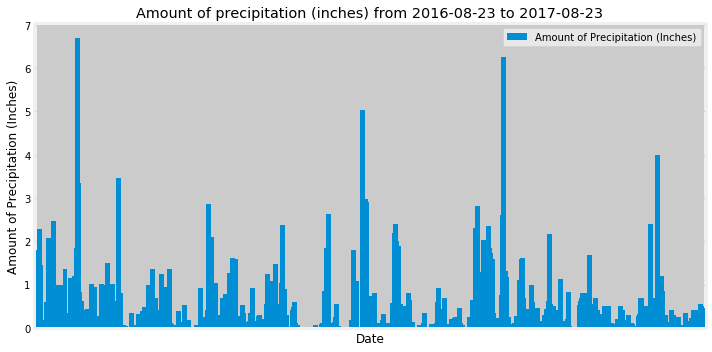

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Calculate the date 1 year ago from the last data point in the database.
last_measurement_data_point_tuple = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
(latest_date, ) = last_measurement_data_point_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores.
data_from_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

# Save the query results as a Pandas DataFrame.
last_year_data_df = pd.DataFrame(data_from_last_year, columns=['date', 'prcp'])

# Drop null values (if any).
last_year_data_df = last_year_data_df.dropna(how="any")

# Set the index to the date column.
last_year_data_df = last_year_data_df.set_index("date")
print(last_year_data_df)

# Sort the dataframe by date.
last_year_data_df = last_year_data_df.sort_values(by=['date'])

# Use pandas plotting with matplotlib to plot the data.

# Plot it.
prcp_plot = last_year_data_df.plot(kind="bar", figsize=(10, 5), width=15)

# Add legend
prcp_plot.legend(["Amount of Precipitation (Inches)"], loc="upper right")

# Add labels to axes.
prcp_plot.set_xlabel("Date")
prcp_plot.set_ylabel("Amount of Precipitation (Inches)")

# Set a title for the chart
prcp_plot.set_title(f"Amount of precipitation (inches) from {date_year_ago} to {latest_date}")

plt.tick_params(
    axis='x',         
    which='both',    
    bottom=False,      
    top=False,        
    labelbottom=False
)

# Tighten the graph up so it displays nicely.
plt.tight_layout()

# Add grid lines.
prcp_plot.grid(zorder=1)

# Save figure
plt.savefig(f"./Images/precipitation_data_from_{date_year_ago}_to_{latest_date}.png", bbox_inches='tight')

# Show graph.
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_data_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset
number_stations = session.query(Station.station).count()

print(f"Number of stations available in this dataset: {number_stations}")
number_stations_df = pd.DataFrame({ "Number of Stations": number_stations}, index=[0])
number_stations_df


Number of stations available in this dataset: 9


,Number of Stations
0,9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    all()

for station, count in station_counts:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count().desc()).\
        first()

(most_active_station_id, ) = most_active_station
print(f"The station id of the most active station is {most_active_station_id}.")

most_active_station_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_station_id) .\
        all()

for lowest_temp, highest_temp, avg_temp in most_active_station_data:
    print(f"The lowest temperature recorded at {most_active_station_id} was {lowest_temp}.")
    print(f"The highest temperature recorded at {most_active_station_id} was {highest_temp}.")
    print(f"The average temperature recorded at {most_active_station_id} was {avg_temp}.")
    
temperature_df = pd.DataFrame({
    "Lowest Temperature": lowest_temp,
    "Highest Temperature": highest_temp,
    "Average Temperature": avg_temp
}, index=[0])

temperature_df


The station id of the most active station is USC00519281.
The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.663781


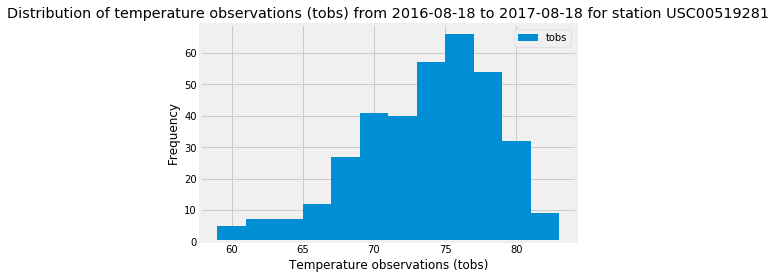

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
measurement_tuple = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_station_id).first()

(latest_date,) = measurement_tuple
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

last_year_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= date_year_ago).all()
    
last_year_data_df = pd.DataFrame(last_year_data, columns=['date', 'tobs'])

last_year_data_df

plt.hist(last_year_data_df["tobs"], bins=12, label="tobs")
plt.ylabel('Frequency')
plt.xlabel('Temperature observations (tobs)')
plt.title(f"Distribution of temperature observations (tobs) from {date_year_ago} to {latest_date} for station {most_active_station_id}")
plt.grid(zorder=0)
plt.legend(loc="upper right")
plt.savefig(f"./Images/tobs_histogram_for_station_{most_active_station_id}.png", bbox_inches='tight')
plt.show()



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
